In [18]:
from types import SimpleNamespace
from collections import Counter
import os
import re
import pathlib
import array
import pickle
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

In [19]:
DATASET_VERSION = 'ca-100'
COMPETITION_ROOT = '../input/vectors3'
DATASET_ROOT = f'../input/text-preprocessing/data/{DATASET_VERSION}'
WORKING_ROOT = f'data/{DATASET_VERSION}'
DATASET_PREFIX = 'ca.wiki'

In [20]:
params = SimpleNamespace(
    embedding_dim = 100,
    window_size = 7,
    batch_size = 1000,
    epochs = 4,
    preprocessed = f'{DATASET_ROOT}/{DATASET_PREFIX}',
    working = f'{WORKING_ROOT}/{DATASET_PREFIX}',
    modelname = f'{WORKING_ROOT}/{DATASET_VERSION}.pt',
    train = True
)

In [21]:
class Vocabulary(object):
    def __init__(self, pad_token='<pad>', unk_token='<unk>', eos_token='<eos>'):
        self.token2idx = {}
        self.idx2token = []
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.eos_token = eos_token
        if pad_token is not None:
            self.pad_index = self.add_token(pad_token)
        if unk_token is not None:
            self.unk_index = self.add_token(unk_token)
        if eos_token is not None:
            self.eos_index = self.add_token(eos_token)

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def get_index(self, token):
        if isinstance(token, str):
            return self.token2idx.get(token, self.unk_index)
        else:
            return [self.token2idx.get(t, self.unk_index) for t in token]

    def __len__(self):
        return len(self.idx2token)

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.__dict__, f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            self.__dict__.update(pickle.load(f))

In [22]:
def batch_generator(idata, target, batch_size, shuffle=True):
    nsamples = len(idata)
    if shuffle:
        perm = np.random.permutation(nsamples)
    else:
        perm = range(nsamples)

    for i in range(0, nsamples, batch_size):
        batch_idx = perm[i:i+batch_size]
        if target is not None:
            yield idata[batch_idx], target[batch_idx]
        else:
            yield idata[batch_idx], None

CBOW model
----------
You can add new parameters to the model in the *\_\_init\_\_()* method with *self.register_buffer()* (for parameters not to be trained):

    self.register_buffer('position_weight', torch.tensor([1,2,3,3,2,1], dtype=torch.float32))

or *nn.Parameter()* (for parameters to be trained)

    self.position_weight = nn.Parameter(torch.tensor([1,2,3,3,2,1], dtype=torch.float32))
    
In both cases, you can reference and use them in the *forward* method as

    self.position_weight

In [23]:
class CBOW(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        self.lin = nn.Linear(embedding_dim, num_embeddings, bias=False)

    # B = Batch size
    # W = Number of context words (left + right)
    # E = embedding_dim
    # V = num_embeddings (number of words)
    def forward(self, input):
        # input shape is (B, W)
        e = self.emb(input)
        # e shape is (B, W, E)
        u = e.sum(dim=1)
        # u shape is (B, E)
        z = self.lin(u)
        # z shape is (B, V)
        return z


class CbowFixedWeights(nn.Module):
    '''
    In this class, the words that are closer to the predicted central word are 
    given more weight, more precisely the weights given to the context words are
    (1,2,3,3,2,1) 
    '''
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        # Define weights parameter
        self.register_buffer('position_weight', torch.tensor([1,2,3,3,2,1], dtype=torch.float32))
        self.lin = nn.Linear(embedding_dim, num_embeddings, bias=False)

    # B = Batch size
    # W = Number of context words (left + right)
    # E = embedding_dim
    # V = num_embeddings (number of words)
    def forward(self, input):
        # input shape is (B, W)
        e = self.emb(input)
        # e shape is (B, W, E)
        # Transpose e in order to be (B, E, W) and then multiply it with [1,2,3,3,2,1]
        u = torch.matmul(torch.transpose(e, 1, 2),self.position_weight)
        # u shape is (B, E)
        v = self.lin(u)
        # v shape is (B, V)
        return v

class CBOW_learnt_weight(nn.Module):
    '''
    In this second class, we learn the weights that multiply each context word vector, instead
    of specifying it. We initialize it with the previous weights because it has sense to give
    more weight to words closer to the central word.
    '''
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        # This time the weights are learnable parameters
        self.position_weight = nn.Parameter(torch.tensor([1,2,3,3,2,1], dtype=torch.float32))
        self.lin = nn.Linear(embedding_dim, num_embeddings, bias=False)

    # B = Batch size
    # W = Number of context words (left + right)
    # E = embedding_dim
    # V = num_embeddings (number of words)
    def forward(self, input):
        # input shape is (B, W)
        e = self.emb(input)
        # Transpose e in order to be (B, E, W) and then multiply it with the learned weights
        u = torch.matmul(torch.transpose(e, 1, 2),self.position_weight)
        # u shape is (B, E)
        v = self.lin(u)
        # v shape is (B, V)
        return v

class CBOW_learnt_position_weight(nn.Module):
    '''
    Finally, train a weight vector for each context word. We initialize it randomly
    as we do not exactly know which values we are looking for.
    '''
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        self.vec_weight = nn.Parameter(torch.randn(params.window_size-1,embedding_dim))
        self.lin = nn.Linear(embedding_dim, num_embeddings, bias=False)

    # B = Batch size
    # W = Number of context words (left + right)
    # E = embedding_dim
    # V = num_embeddings (number of words)
    def forward(self, input):
        # input shape is (B, W)
        e = self.emb(input)
        # e shape is (B, W, E)
        e_w = torch.mul(e,self.vec_weight)
        # e_w shape is again (B, W, E)
        u = e_w.sum(dim=1)
        # u shape is (B, E)
        v = self.lin(u)
        # v shape is (B, V)
        return v

We can visually show how this model works:

<div style="text-align:center">
    <img src="https://drive.google.com/uc?id=1INeftgKRCS0QWZu9InCDZ42a5fph3jQX" alt="drawing" width="800" height="800"/>
</div>

We train the model to learn matrices $\mathbf{E}$ and $\mathbf{W}$. Probabilities $P(w_t|w_{c-m},\cdots,w_{c+m})$ can be obtained by applying the softmax function to the output vector $\mathbf{z}$. However, our loss function [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) takes care of this.


In [24]:
def load_preprocessed_dataset(prefix):
    # Try loading precomputed vocabulary and preprocessed data files
    token_vocab = Vocabulary()
    token_vocab.load(f'{prefix}.vocab')
    data = []
    for part in ['train', 'valid', 'test']:
        with np.load(f'{prefix}.{part}.npz') as set_data:
            idata, target = set_data['idata'], set_data['target']
            data.append((idata, target))
            print(f'Number of samples ({part}): {len(target)}')
    print("Using precomputed vocabulary and data files")
    print(f'Vocabulary size: {len(token_vocab)}')
    return token_vocab, data

In [25]:
def train(model, criterion, optimizer, idata, target, batch_size, device, log=False):
    model.train()
    total_loss = 0
    ncorrect = 0
    ntokens = 0
    niterations = 0
    for X, y in batch_generator(idata, target, batch_size, shuffle=True):
        # Get input and target sequences from batch
        X = torch.tensor(X, dtype=torch.long, device=device)
        y = torch.tensor(y, dtype=torch.long, device=device)

        model.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        # Training statistics
        total_loss += loss.item()
        ncorrect += (torch.max(output, 1)[1] == y).sum().item()
        ntokens += y.numel()
        niterations += 1
        if niterations == 200 or niterations == 500 or niterations % 1000 == 0:
            print(f'Train: wpb={ntokens//niterations}, num_updates={niterations}, accuracy={100*ncorrect/ntokens:.1f}, loss={total_loss/ntokens:.2f}')

    total_loss = total_loss / ntokens
    accuracy = 100 * ncorrect / ntokens
    if log:
        print(f'Train: wpb={ntokens//niterations}, num_updates={niterations}, accuracy={accuracy:.1f}, loss={total_loss:.2f}')
    return accuracy, total_loss

In [26]:
def validate(model, criterion, idata, target, batch_size, device):
    model.eval()
    total_loss = 0
    ncorrect = 0
    ntokens = 0
    niterations = 0
    y_pred = []
    with torch.no_grad():
        for X, y in batch_generator(idata, target, batch_size, shuffle=False):
            # Get input and target sequences from batch
            X = torch.tensor(X, dtype=torch.long, device=device)
            output = model(X)
            if target is not None:
                y = torch.tensor(y, dtype=torch.long, device=device)
                loss = criterion(output, y)
                total_loss += loss.item()
                ncorrect += (torch.max(output, 1)[1] == y).sum().item()
                ntokens += y.numel()
                niterations += 1
            else:
                pred = torch.max(output, 1)[1].detach().to('cpu').numpy()
                y_pred.append(pred)

    if target is not None:
        total_loss = total_loss / ntokens
        accuracy = 100 * ncorrect / ntokens
        return accuracy, total_loss
    else:
        return np.concatenate(y_pred)

In [27]:
# Create working dir
pathlib.Path(WORKING_ROOT).mkdir(parents=True, exist_ok=True)

In [28]:
# Select device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("WARNING: Training without GPU can be very slow!")

In [29]:
vocab, data = load_preprocessed_dataset(params.preprocessed)

Number of samples (train): 82284341
Number of samples (valid): 164765
Number of samples (test): 165837
Using precomputed vocabulary and data files
Vocabulary size: 100002


In [30]:
# 'El Periodico' validation dataset
valid_x_df = pd.read_csv(f'{COMPETITION_ROOT}/x_valid.csv')
tokens = valid_x_df.columns[1:]
valid_x = valid_x_df[tokens].apply(vocab.get_index).to_numpy(dtype='int32')
valid_y_df = pd.read_csv(f'{COMPETITION_ROOT}/y_valid.csv')
valid_y = valid_y_df['token'].apply(vocab.get_index).to_numpy(dtype='int32')

In [31]:
# 'El Periodico' test dataset
valid_x_df = pd.read_csv(f'{COMPETITION_ROOT}/x_test.csv')
test_x = valid_x_df[tokens].apply(vocab.get_index).to_numpy(dtype='int32')

In [32]:
model = CBOW(len(vocab), params.embedding_dim).to(device)
print(model)
for name, param in model.named_parameters():
    print(f'{name:20} {param.numel()} {list(param.shape)}')
print(f'TOTAL                {sum(p.numel() for p in model.parameters())}')

CBOW(
  (emb): Embedding(100002, 100, padding_idx=0)
  (lin): Linear(in_features=100, out_features=100002, bias=False)
)
emb.weight           10000200 [100002, 100]
lin.weight           10000200 [100002, 100]
TOTAL                20000400


Note that $\textit{lin}$ layer transposes $\textit{lin.weight}$ before performing the multilplication.

The [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) criterion combines *nn.LogSoftmax()* and *nn.NLLLoss()* in one single class.

In [33]:
criterion = nn.CrossEntropyLoss(reduction='sum')

In [34]:
def trainModel(saveName, model):
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters())

    train_accuracy = []
    wiki_accuracy = []
    valid_accuracy = []
    for epoch in range(params.epochs):
        acc, loss = train(model, criterion, optimizer, data[0][0], data[0][1], params.batch_size, device, log=True)
        train_accuracy.append(acc)
        print(f'| epoch {epoch:03d} | train accuracy={acc:.1f}%, train loss={loss:.2f}')
        acc, loss = validate(model, criterion, data[1][0], data[1][1], params.batch_size, device)
        wiki_accuracy.append(acc)
        print(f'| epoch {epoch:03d} | valid accuracy={acc:.1f}%, valid loss={loss:.2f} (wikipedia)')
        acc, loss = validate(model, criterion, valid_x, valid_y, params.batch_size, device)
        valid_accuracy.append(acc)
        print(f'| epoch {epoch:03d} | valid accuracy={acc:.1f}%, valid loss={loss:.2f} (El Periódico)')

    # Save model
    torch.save(model.state_dict(), params.modelname)
    # Return the accuracies
    return train_accuracy, wiki_accuracy, valid_accuracy

def plot_accuracies(train_accuracy, wiki_accuracy, valid_accuracy):
    import matplotlib.pyplot as plt
    plt.plot(train_accuracy,label = "Training Accuracy")
    plt.plot(wiki_accuracy,label = "Wikipedia Test Accuracy")
    plt.plot(valid_accuracy,label = "Periodico Test Accuracy")
    plt.xlabel("Epoch")
    plt.title("Accuracies per epoch")
    plt.legend()

In [35]:
cnstWeightModel = CbowFixedWeights(len(vocab), params.embedding_dim).to(device)
learntWeightModel = CBOW_learnt_weight(len(vocab), params.embedding_dim).to(device)
learntVectorsModel = CBOW_learnt_position_weight(len(vocab), params.embedding_dim).to(device)

Train: wpb=1000, num_updates=200, accuracy=3.9, loss=10.64
Train: wpb=1000, num_updates=500, accuracy=7.3, loss=9.14
Train: wpb=1000, num_updates=1000, accuracy=10.2, loss=8.17
Train: wpb=1000, num_updates=2000, accuracy=13.2, loss=7.36
Train: wpb=1000, num_updates=3000, accuracy=15.1, loss=6.96
Train: wpb=1000, num_updates=4000, accuracy=16.5, loss=6.71
Train: wpb=1000, num_updates=5000, accuracy=17.6, loss=6.53
Train: wpb=1000, num_updates=6000, accuracy=18.4, loss=6.39
Train: wpb=1000, num_updates=7000, accuracy=19.2, loss=6.28
Train: wpb=1000, num_updates=8000, accuracy=19.9, loss=6.18
Train: wpb=1000, num_updates=9000, accuracy=20.4, loss=6.10
Train: wpb=1000, num_updates=10000, accuracy=20.9, loss=6.03
Train: wpb=1000, num_updates=11000, accuracy=21.4, loss=5.97
Train: wpb=1000, num_updates=12000, accuracy=21.8, loss=5.92
Train: wpb=1000, num_updates=13000, accuracy=22.2, loss=5.87
Train: wpb=1000, num_updates=14000, accuracy=22.5, loss=5.82
Train: wpb=1000, num_updates=15000, ac

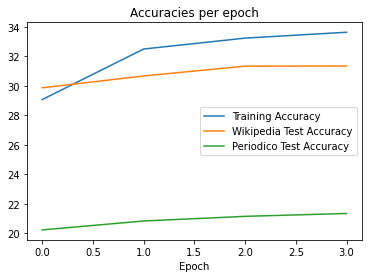

In [36]:
# Train constant weight model
train_accuracy, wiki_accuracy, valid_accuracy = trainModel("cnstWeight",cnstWeightModel)
plot_accuracies(train_accuracy, wiki_accuracy, valid_accuracy)

Train: wpb=1000, num_updates=200, accuracy=4.0, loss=10.49
Train: wpb=1000, num_updates=500, accuracy=7.5, loss=9.02
Train: wpb=1000, num_updates=1000, accuracy=10.5, loss=8.07
Train: wpb=1000, num_updates=2000, accuracy=13.7, loss=7.24
Train: wpb=1000, num_updates=3000, accuracy=15.8, loss=6.82
Train: wpb=1000, num_updates=4000, accuracy=17.3, loss=6.55
Train: wpb=1000, num_updates=5000, accuracy=18.5, loss=6.36
Train: wpb=1000, num_updates=6000, accuracy=19.4, loss=6.21
Train: wpb=1000, num_updates=7000, accuracy=20.3, loss=6.09
Train: wpb=1000, num_updates=8000, accuracy=21.0, loss=5.99
Train: wpb=1000, num_updates=9000, accuracy=21.6, loss=5.90
Train: wpb=1000, num_updates=10000, accuracy=22.2, loss=5.83
Train: wpb=1000, num_updates=11000, accuracy=22.7, loss=5.76
Train: wpb=1000, num_updates=12000, accuracy=23.2, loss=5.70
Train: wpb=1000, num_updates=13000, accuracy=23.6, loss=5.65
Train: wpb=1000, num_updates=14000, accuracy=23.9, loss=5.60
Train: wpb=1000, num_updates=15000, ac

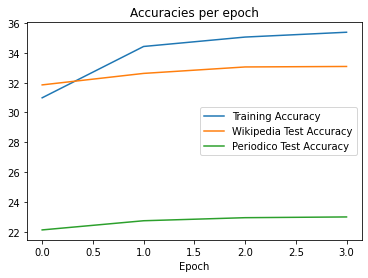

In [37]:
# Train learnt weights model
train_accuracy, wiki_accuracy, valid_accuracy = trainModel("learntWeight", learntWeightModel)
plot_accuracies(train_accuracy, wiki_accuracy, valid_accuracy)

Train: wpb=1000, num_updates=200, accuracy=4.1, loss=10.15
Train: wpb=1000, num_updates=500, accuracy=9.0, loss=8.65
Train: wpb=1000, num_updates=1000, accuracy=12.9, loss=7.69
Train: wpb=1000, num_updates=2000, accuracy=16.9, loss=6.88
Train: wpb=1000, num_updates=3000, accuracy=19.3, loss=6.45
Train: wpb=1000, num_updates=4000, accuracy=21.2, loss=6.17
Train: wpb=1000, num_updates=5000, accuracy=22.6, loss=5.96
Train: wpb=1000, num_updates=6000, accuracy=23.7, loss=5.80
Train: wpb=1000, num_updates=7000, accuracy=24.7, loss=5.67
Train: wpb=1000, num_updates=8000, accuracy=25.6, loss=5.56
Train: wpb=1000, num_updates=9000, accuracy=26.3, loss=5.47
Train: wpb=1000, num_updates=10000, accuracy=26.9, loss=5.39
Train: wpb=1000, num_updates=11000, accuracy=27.5, loss=5.32
Train: wpb=1000, num_updates=12000, accuracy=28.1, loss=5.25
Train: wpb=1000, num_updates=13000, accuracy=28.5, loss=5.19
Train: wpb=1000, num_updates=14000, accuracy=29.0, loss=5.14
Train: wpb=1000, num_updates=15000, ac

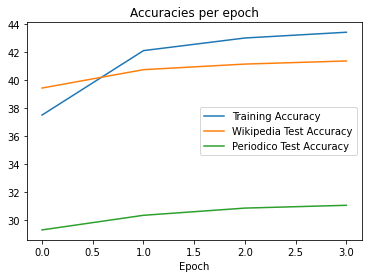

In [38]:
# Train learnt vectors model
train_accuracy, wiki_accuracy, valid_accuracy = trainModel("learntVectors", learntVectorsModel)
plot_accuracies(train_accuracy, wiki_accuracy, valid_accuracy)

In [39]:
def generateSubmissions(save_name, model):
    # 'El Periodico' test dataset
    valid_x_df = pd.read_csv(f'{COMPETITION_ROOT}/x_test.csv')
    test_x = valid_x_df[tokens].apply(vocab.get_index).to_numpy(dtype='int32')
    # Test prediction
    y_pred = validate(model, None, test_x, None, params.batch_size, device)
    y_token = [vocab.idx2token[index] for index in y_pred]
    submission = pd.DataFrame({'id':valid_x_df['id'], 'token': y_token}, columns=['id', 'token'])
    print(submission.head())
    submission.to_csv('submission.csv', index=False)

In [40]:
generateSubmissions("cnstWeight", cnstWeightModel)
generateSubmissions("learntWeight", learntWeightModel)
generateSubmissions("learntVectors", learntVectorsModel)

   id token
0   0     l
1   1     n
2   2    es
3   3    hi
4   4    un
   id  token
0   0      l
1   1   hagi
2   2  haver
3   3     hi
4   4     un
   id  token
0   0      l
1   1      s
2   2  haver
3   3      s
4   4     un
